<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_HR_gr1/blob/main/Kiparenko%20Nikolai/INSPECTRUM_CLINIC_HR_RECSYS_GR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
# Работа с массивами данных
import numpy as np 

# Работа с таблицами
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, ReLU 

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Кодирование тестовых меток
from sklearn.preprocessing import LabelEncoder

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split

# автоматически парсит строку и сохранит ее в переменной datetime
import datetime

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Запись в файлы и чтение из файлов структур данных Python
import pickle

# Отрисовка графиков
import matplotlib.pyplot as plt


%matplotlib inline

In [73]:
import gdown                                      # Подключим функцию gdown
#Грузим файл
gdown.download('https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_HR/datasets/%D0%94%D0%B0%D1%82%D0%B0%D0%A1%D0%B5%D1%82%20%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0%20%D1%80%D0%B5%D0%B7%D1%8E%D0%BC%D0%B5%20581%20%D1%80%D0%B5%D0%B7%D1%8E%D0%BC%D0%B5.xlsx','dataS.xlsx', quiet=True)   

'dataS.xlsx'

In [74]:
#Читаем файл
data = pd.read_excel (r'dataS.xlsx', index_col=0)
data.max_columns = 30
data.columns = ['Response_date', 'Full_name', 'Gender', 'Salary', 'Job', 'City', 'Employment', 'Schedule', 'Experience', 'Last_place', 'Position', 'Education', 'Update_resume', 'Suitable']

In [4]:
data.head(5)

,Response_date,Full_name,Gender,Salary,Job,City,Employment,Schedule,Experience,Last_place,Position,Education,Update_resume,Suitable
0,2023-02-23 00:00:00,Bessonova Mariya,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,Ефремова Екатерина Вячеславовна,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,Фролов Артур Михайлович,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,Директор по маркетингу и бренд-менеджер,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,Хозаев Расул Шагаманович,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,Шадрин Олег Михайлович,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да


In [76]:
#Разбираем Дату раждения
Birth = data['Gender'].apply(lambda x: x.split(',')[2].strip() if len(x.split(','))>2 else '')
data = data.assign(Birth=Birth)
#Разбираем Возраст
Age = data['Gender'].apply(lambda x: x.split(',')[1].strip() if len(x.split(','))>1 else '')
data = data.assign(Age=Age)

In [75]:
#Формируем список месяцев
month_name = {1: 'января', 2: 'февраля', 3: 'марта', 4: 'апреля', 5: 'мая', 6: 'июня',
      7: 'июля', 8: 'августа', 9: 'сентября', 10: 'октября', 11: 'ноября', 12: 'декабря'}


In [ ]:
for i, row in data.iterrows():
  #Gender
  row.Gender = row.Gender.split(',')[0].strip() 
  #Женщина = 0, Мужчина = 1
  row.Gender = row.Gender.replace('Женщина','0')
  row.Gender = row.Gender.replace('Мужчина','1')
  row.Gender = int(row.Gender)

  #Birth
  row.Birth = row.Birth.replace('родился','')
  row.Birth = row.Birth.replace('родилась','')
 
  #Age
  row.Age = row.Age.replace('года','')
  row.Age = row.Age.replace('год','')
  row.Age = row.Age.replace('лет','')
  row.Age = row.Age='' if 0 else row.Age

  try:
    row.Age = int(row.Age)
  except (IndexError, TypeError, ValueError):
    print(row.Age)
    row.Age = 0

  #Salary
  row.Salary = row.Salary.replace(' ','') 
  row.Salary = str(float(row.Salary.replace('KGS',''))*0.89)      if row.Salary.find('KGS') != -1 else row.Salary
  row.Salary = str(float(row.Salary.replace('KZT',''))*0.18)      if row.Salary.find('KZT') != -1 else row.Salary
  row.Salary = str(float(row.Salary.replace('USD',''))*78.00)     if row.Salary.find('USD') != -1 else row.Salary
  row.Salary = str(float(row.Salary.replace('EUR',''))*85.00)     if row.Salary.find('EUR') != -1 else row.Salary
  row.Salary = row.Salary.replace('руб.','')
  row.Salary = row.Salary.replace('руб','')
  row.Salary = row.Salary.replace('неуказана','0')
  row.Salary = int(float(row.Salary)) 

  #Experience
  row.Experience = row.Experience.replace('Опыт работы —','')
  row.Experience = row.Experience.replace('Опыт работы','')
  row.Experience = row.Experience.replace('года',';')
  row.Experience = row.Experience.replace('лет',';')
  row.Experience = row.Experience.replace('годов',';')
  row.Experience = row.Experience.replace('год',';')
  row.Experience = row.Experience.replace('года',';')
  row.Experience = row.Experience.replace('месяцев','')
  row.Experience = row.Experience.replace('месяца','')
  row.Experience = row.Experience.replace('месяц','')
  row.Experience = row.Experience.replace('нет','0')
  #Приводим к месяцам, если были года умножаем на 12 иначе берем как есть 
  row.Experience = (int(row.Experience.split(';')[0].strip()) * 12 + (int(row.Experience.split(';')[1].strip())) if row.Experience.split(';')[1].strip() != '' else int(row.Experience.split(';')[0].strip()) * 12) if len(row.Experience.split(';')) >1 else int(row.Experience.strip()) 

  #Schedule
  #вахтовый метод = 0, удаленная работа = 1, гибкий график = 2, полный день = 3, сменный график = 4
  row.Schedule = row.Schedule.replace('вахтовый метод','0')
  row.Schedule = row.Schedule.replace('удаленная работа','1')
  row.Schedule = row.Schedule.replace('гибкий график','2')
  row.Schedule = row.Schedule.replace('полный день','3')
  row.Schedule = row.Schedule.replace('сменный график','4')

  #Employment
  #проектная работа = 0, неполный рабочий день = 1, полный рабочий день = 2, полная занятость = 3, частичная занятость = 4, стажировка = 5, волонтерство = 6
  row.Employment = row.Employment.replace('проектная работа','0')
  row.Employment = row.Employment.replace('неполный рабочий день','1')
  row.Employment = row.Employment.replace('полный рабочий день','2')
  row.Employment = row.Employment.replace('полная занятость','3')
  row.Employment = row.Employment.replace('частичная занятость','4')
  row.Employment = row.Employment.replace('стажировка','5')
  row.Employment = row.Employment.replace('волонтерство','6')

  #Birth
  for i in month_name:
     row.Birth         = row.Birth.replace(month_name[i],'-'+str(i)+'-')
 
  row.Birth         = row.Birth.replace('родился','')
  row.Birth         = row.Birth.replace('родилась','')
  row.Birth         = row.Birth.replace(' -','-')
  row.Birth         = row.Birth.replace('- ','-')
  row.Birth         = row.Birth+' 00:00:00'

  row.Birth = '1-1-1' +row.Birth if row.Birth == ' 00:00:00' else row.Birth
  day = int(row.Birth.split('-')[0].strip()) 
  month = int(row.Birth.split('-')[1].strip()) 
  year = row.Birth.split('-')[2].strip() 
  time = year.split(' ')[1].strip()
  year = int(year.split(' ')[0].strip())

  row.Birth = int(datetime.datetime(year,month,day).utcnow().timestamp())

  #Update_resume 
  for i in month_name:
    row.Update_resume = row.Update_resume.replace(month_name[i],'-'+str(i)+'-')
 
  row.Update_resume = row.Update_resume.replace('в','')
  row.Update_resume = row.Update_resume.replace(' -','-')
  row.Update_resume = row.Update_resume.replace('- ','-')
  row.Update_resume = row.Update_resume+':00'

  day = int(row.Update_resume.split('-')[0].strip()) 
  month = int(row.Update_resume.split('-')[1].strip()) 
  year = row.Update_resume.split('-')[2].strip() 
  year = year.replace('  ',';')
  year = year.replace(' ',';')
   
  time = year.split(';')[1].strip()
  year = int(year.split(';')[0].strip())
  hour = int(time.split(':')[0].strip())
  minute = int(time.split(':')[1].strip())

  row.Update_resume = int(datetime.datetime(year,month,day,hour,minute,0).utcnow().timestamp())

  #Response_date
  row.Response_date = int(datetime.datetime.utcnow().timestamp())

In [78]:
#Переведем в бинарные значения

#проектная работа = 0, неполный рабочий день = 1, полный рабочий день = 2, полная занятость = 3, частичная занятость = 4, стажировка = 5, волонтерство = 6
Employment_0 = data['Employment'].apply(lambda x: 1 if x.find('0') else 0)
Employment_1 = data['Employment'].apply(lambda x: 1 if x.find('1') else 0)
Employment_2 = data['Employment'].apply(lambda x: 1 if x.find('2') else 0)
Employment_3 = data['Employment'].apply(lambda x: 1 if x.find('3') else 0)
Employment_4 = data['Employment'].apply(lambda x: 1 if x.find('4') else 0)
Employment_5 = data['Employment'].apply(lambda x: 1 if x.find('5') else 0)
Employment_6 = data['Employment'].apply(lambda x: 1 if x.find('6') else 0)

data = data.assign(Employment_0=Employment_0,
                    Employment_1=Employment_1,
                    Employment_2=Employment_2,
                    Employment_3=Employment_3,
                    Employment_4=Employment_4,
                    Employment_5=Employment_5,
                    Employment_6=Employment_6)

#вахтовый метод = 0, удаленная работа = 1, гибкий график = 2, полный день = 3, сменный график = 4
Schedule_0 = data['Schedule'].apply(lambda x: 1 if x.find('0') else 0)
Schedule_1 = data['Schedule'].apply(lambda x: 1 if x.find('1') else 0)
Schedule_2 = data['Schedule'].apply(lambda x: 1 if x.find('2') else 0)
Schedule_3 = data['Schedule'].apply(lambda x: 1 if x.find('3') else 0)
Schedule_4 = data['Schedule'].apply(lambda x: 1 if x.find('4') else 0)

data = data.assign(Schedule_0=Schedule_0,
                    Schedule_1=Schedule_1,
                    Schedule_2=Schedule_2,
                    Schedule_3=Schedule_3,
                    Schedule_4=Schedule_4)

data = data.drop(columns=['Schedule', 'Employment'])

In [80]:
#City
tokenizer = Tokenizer(num_words=30, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.City) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
City_Indexes = tokenizer.texts_to_sequences(data.City)
data = data.assign(City=City_Indexes)

In [81]:
#Full_name
tokenizer = Tokenizer(num_words=100, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Full_name)

Full_name_Indexes = tokenizer.texts_to_sequences(data.Full_name) 
data = data.assign(Full_name=Full_name_Indexes)

In [82]:
#Education
tokenizer = Tokenizer(num_words=200, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Education) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности

Education_Indexes = tokenizer.texts_to_sequences(data.Education) 
data = data.assign(Education=Education_Indexes)

In [83]:
#Job
tokenizer = Tokenizer(num_words=150, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Job) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности

Job_Indexes = tokenizer.texts_to_sequences(data.Job) 
data = data.assign(Job=Job_Indexes)

In [84]:
#Last_place
tokenizer = Tokenizer(num_words=150, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Last_place) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности

Last_place_Indexes = tokenizer.texts_to_sequences(data.Last_place) 
data = data.assign(Last_place=Last_place_Indexes)

In [85]:
#Position
tokenizer = Tokenizer(num_words=150, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Position) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности

Position_Indexes = tokenizer.texts_to_sequences(data.Position) 
data = data.assign(Position=Position_Indexes)

In [86]:
#Suitable
#Список ответов делаем
listAnswers = []
#Обработаем отдельно колонку с ответами
for i, row in data.iterrows():
   a = 1 if str(row.Suitable).find('да') != -1 else 0
   listAnswers.append([a])
answers = np.array(listAnswers)
print(answers.shape)

(579, 1)


In [87]:
data = data.drop(columns=['Suitable'])

In [ ]:
data.info()

In [90]:
#Приведим все списки к однообразию
data.Response_date = data.Response_date.astype('int')
data.Gender = data.Gender.astype('int')
data.Salary = data.Salary.astype('int')
data.Update_resume = data.Update_resume.astype('int')
data.Birth = data.Birth.astype('int')
data.Age = data.Age.astype('int')

#Находим максимальную длину
Full_nameMaxI = 0
PositionMaxI = 0
Last_placeMaxI = 0
JobMaxI = 0
EducationMaxI = 0
CityMaxI = 0
for i, row in data.iterrows():
    Full_nameMaxI   = max(Full_nameMaxI,len(row.Full_name))
    PositionMaxI    = max(PositionMaxI,len(row.Position))
    Last_placeMaxI  = max(Last_placeMaxI,len(row.Last_place))
    JobMaxI         = max(JobMaxI,len(row.Job))
    EducationMaxI   = max(EducationMaxI,len(row.Education))
    CityMaxI        = max(CityMaxI,len(row.City))


In [91]:
#обрабатываем данные list
dataList = [] 
for i, row in data.iterrows():
      row.Full_name     = np.array(row.Full_name+[0 for x in range(Full_nameMaxI-len(row.Full_name))])
      row.Position      = np.array(row.Position+[0 for x in range(PositionMaxI-len(row.Position))])
      row.Last_place    = np.array(row.Last_place+[0 for x in range(Last_placeMaxI-len(row.Last_place))])
      row.Job           = np.array(row.Job+[0 for x in range(JobMaxI-len(row.Job))])
      row.Education     = np.array(row.Education+[0 for x in range(EducationMaxI-len(row.Education))])
      row.City          = np.array(row.City+[0 for x in range(CityMaxI-len(row.City))])
      
      #row_data = np.hstack(row)
      row_data = np.hstack([
                            row.Full_name,
                            row.Position,
                            row.Last_place,
                            row.Job,
                            row.Education,
                            row.City,
                            row.Response_date,
                            row.Gender,
                            row.Salary,
                            row.Update_resume,
                            row.Birth,
                            row.Age,
                            row.Employment_0,
                            row.Employment_1,
                            row.Employment_2,
                            row.Employment_3,
                            row.Employment_4,
                            row.Employment_5,
                            row.Employment_6,
                            row.Schedule_0,
                            row.Schedule_1,
                            row.Schedule_2,
                            row.Schedule_3,
                            row.Schedule_4]
                          )
      
      dataList.append(row_data)

dataset = np.array(dataList) #, dtype=np.float
print(dataset.shape)

(579, 213)


In [ ]:
data.info()

In [ ]:
#Смотрим что получилось
data.max_columns = 30
data.head(-15)

In [ ]:
for row in dataset:
    print(dataset)

In [92]:
# Делаем выборки для обучения
x_train, x_test, y_train, y_test = train_test_split(dataset, # набор параметров
                                                    answers, # набор меток классов
                                                    test_size=0.2, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость

In [93]:
x_train.shape

(463, 213)

In [107]:
# Оптимизаторы
from tensorflow.keras.optimizers import Adam
# Основные слои
from tensorflow.keras.layers import ReLU, Flatten

# Создание последовательной модели
model = Sequential()
model.add(Dense(60, activation='relu',input_dim=x_train.shape[1]))
model.add(Activation('relu'))
#model.add(BatchNormalization())
#model.add(BatchNormalization(input_dim=x_train.shape[1]))
model.add(Dense(1000, activation='tanh'))
model.add(Dense(30, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Flatten())
#model.add(Dense(30, activation='softmax'))
#model.add(Activation('relu'))
#model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid')) #softmax linear

# Компиляция модели
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

#model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

# Обучение сети
history = model.fit(x_train, 
                    y_train, #y_train
                    batch_size=8, 
                    epochs=10,
                    validation_split=0.2, 
                    verbose=1)

Epoch 1/10
47/47 [==============================] - 3s 8ms/step - loss: 0.1235 - accuracy: 0.9622 - val_loss: 0.1992 - val_accuracy: 0.9570
Epoch 2/10
47/47 [==============================] - 0s 4ms/step - loss: 0.0885 - accuracy: 0.9838 - val_loss: 0.1837 - val_accuracy: 0.9570
Epoch 3/10
47/47 [==============================] - 0s 6ms/step - loss: 0.0885 - accuracy: 0.9838 - val_loss: 0.1826 - val_accuracy: 0.9570
Epoch 4/10
47/47 [==============================] - 0s 6ms/step - loss: 0.0865 - accuracy: 0.9838 - val_loss: 0.1848 - val_accuracy: 0.9570
Epoch 5/10
47/47 [==============================] - 0s 6ms/step - loss: 0.0911 - accuracy: 0.9838 - val_loss: 0.1807 - val_accuracy: 0.9570
Epoch 6/10
47/47 [==============================] - 0s 5ms/step - loss: 0.0870 - accuracy: 0.9838 - val_loss: 0.2351 - val_accuracy: 0.9570
Epoch 7/10
47/47 [==============================] - 0s 6ms/step - loss: 0.0886 - accuracy: 0.9838 - val_loss: 0.2210 - val_accuracy: 0.9570
Epoch 8/10
47/47 [==

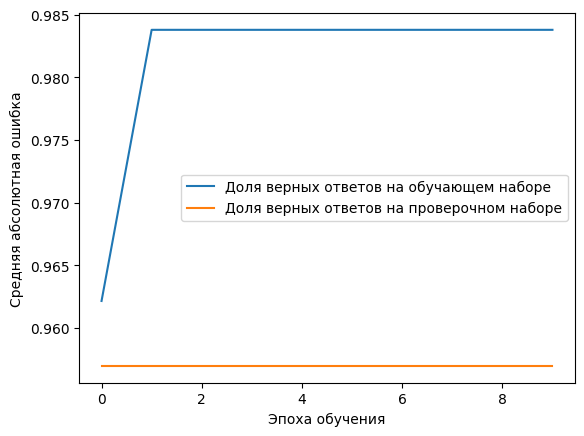

In [108]:
# Визуализация точности на обучающей выборке
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе') #mae
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе') #val_mae
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [109]:
# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Проверка работы сети - предсказание на тренировочной выборке
pred = model.predict(x_train)

# Расчет среднего значения ошибки 
print((abs(pred - y_train)).mean())         # Расчет вручную
print(mean_absolute_error(pred, y_train))   # Расчет с помощью готовой функции

15/15 [==============================] - 0s 2ms/step
0.03225162461778193
0.03225162461778193
